In [1]:
import pandas as pd
import numpy as np
import sqlalchemy
pd.set_option('display.max.columns',None)
pd.options.display.max_colwidth = 100

In [2]:
# Uploading Edinburgh bikes data file.
edbikes_df = pd.read_csv('edinburgh_bikes_202205172048.csv',delimiter=';', decimal=',',index_col=0)
edbikes_df.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
index,,,,,,,,,,,,,
0,2018-09-15 08:52:05,2018-09-15 09:11:48,1182,247,Charlotte Square,North Corner of Charlotte Square,55.95233546161639,-3.207101172107286,259,St Andrew Square,North East corner,55.95472778937899,-3.192652969253117
1,2018-09-15 09:24:33,2018-09-15 09:41:09,995,259,St Andrew Square,North East corner,55.95474881217642,-3.192773668658787,262,Canonmills,near Tesco's,55.96280408759764,-3.196283585062929
2,2018-09-15 09:48:54,2018-09-15 10:46:40,3466,262,Canonmills,near Tesco's,55.96280408759764,-3.196283585062929,250,Victoria Quay,Entrance to Scottish Government Office,55.977637787726984,-3.174115590621568
3,2018-09-16 12:01:36,2018-09-16 12:25:26,1430,255,Kings Buildings 4,X-Y Cafe,55.92200087060626,-3.1769018141649212,254,Kings Building 3,Kings Building House,55.923478807846635,-3.175384584907078
4,2018-09-16 12:03:43,2018-09-16 12:11:16,452,255,Kings Buildings 4,X-Y Cafe,55.92200087060626,-3.1769018141649212,253,Kings Building 2,Sanderson Building,55.92320215516664,-3.17164624536349


In [3]:
# Data exploration: time frame. Table contains Edinburgh bikes borrowings from September 15th, 2018 until end June 2021.

edbikes_df[['started_at','ended_at']].sort_values('started_at')

,started_at,ended_at
index,,
0,2018-09-15 08:52:05,2018-09-15 09:11:48
1,2018-09-15 09:24:33,2018-09-15 09:41:09
2,2018-09-15 09:48:54,2018-09-15 10:46:40
3,2018-09-16 12:01:36,2018-09-16 12:25:26
4,2018-09-16 12:03:43,2018-09-16 12:11:16
...,...,...
12636,2021-06-30 23:30:31,2021-07-01 00:06:10
12637,2021-06-30 23:36:16,2021-07-01 00:05:40
12638,2021-06-30 23:49:03,2021-07-01 00:11:25


In [4]:
# Start stations. There are 198 stations at least once used for start.
start = (edbikes_df[['start_station_id','start_station_name','start_station_latitude','start_station_longitude']].drop_duplicates(subset='start_station_id')
.rename(columns={'start_station_id':'station_id','start_station_name':'station_name','start_station_latitude':'latitude','start_station_longitude':'longitude'})
)
print('Start stations:')
print('\n',start)

Start stations:

        station_id              station_name           latitude  \
index                                                            
0             247          Charlotte Square  55.95233546161639   
1             259          St Andrew Square  55.95474881217642   
2             262                Canonmills  55.96280408759764   
3             255         Kings Buildings 4  55.92200087060626   
5             253          Kings Building 2  55.92320215516664   
...           ...                       ...                ...   
4659         1860     Ingliston Park & Ride   55.9387919459937   
579          2259          Leith Walk North  55.96791807044289   
15127        2263          Musselburgh Lidl  55.94388031687606   
21035        2265  Musselburgh Brunton Hall  55.94400897108537   
5853         2268              Picady Place  55.95653524179326   

                 longitude  
index                       
0       -3.207101172107286  
1       -3.192773668658787  
2      

In [5]:
# End stations. There are 199 stations at least once used to end the borrowing.
end = (edbikes_df[['end_station_id','end_station_name','end_station_latitude','end_station_longitude']].drop_duplicates(subset='end_station_id')
       .rename(columns={'end_station_id':'station_id','end_station_name':'station_name','end_station_latitude':'latitude','end_station_longitude':'longitude'})
      )
print("End stations:")
print('\n',end)

End stations:

        station_id              station_name            latitude  \
index                                                             
0             259          St Andrew Square   55.95472778937899   
1             262                Canonmills   55.96280408759764   
2             250             Victoria Quay  55.977637787726984   
3             254          Kings Building 3  55.923478807846635   
4             253          Kings Building 2   55.92320215516664   
...           ...                       ...                 ...   
12197        1859    Edinburgh Park Central  55.931168715771065   
855          2259          Leith Walk North   55.96791807044289   
14980        2263          Musselburgh Lidl   55.94388031687606   
21035        2265  Musselburgh Brunton Hall   55.94400897108537   
5806         2268              Picady Place   55.95653524179326   

                longitude  
index                      
0      -3.192652969253117  
1      -3.196283585062929  


In [6]:
# All stations. There are 200 stations all together at least once used to start or at least once to end.
stations = pd.concat([end,start]).drop_duplicates().sort_values('station_id')
print("All stations at least once used to start or once to end:")
print('\n',stations)

All stations at least once used to start or once to end:

        station_id              station_name            latitude  \
index                                                             
27            171             George Square   55.94308406301113   
48            183           Waverley Bridge   55.95134439884462   
14            189             City Chambers   55.95010933017899   
135           225            Waverley Court   55.95173449698344   
1278          241                     Depot   55.97237325804326   
...           ...                       ...                 ...   
10024        1877         Port Edgar Marina  55.992957267668345   
855          2259          Leith Walk North   55.96791807044289   
14980        2263          Musselburgh Lidl   55.94388031687606   
21035        2265  Musselburgh Brunton Hall   55.94400897108537   
5806         2268              Picady Place   55.95653524179326   

                longitude  
index                      
27     -3.188

According to stations names some of them should be temporary: Launch Day Event, Royal Highland Show - East Gate (19th to 23rd June), Royal Highland Show - West Gate (19th to 23rd June), 
Ingliston Park and Ride (19th to 23rd June), Meadows - Edinburgh Climate Festival, Holyrood Park - Woman's Tour Of Scotland (Event 11/08/19), Pleasance - Edinburgh University Sports Fair,
HSBC UK Lets Ride - Meadows Event, Cycling Scotland Conference.



In [6]:
# Temporary stations time frame.
(edbikes_df.query("start_station_id in (267,980,981,982,991,1032,1057,1094,1740) or end_station_id in (267,980,981,982,991,1032,1057,1094,1740)")
 .sort_values('start_station_id')
)

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude
index,,,,,,,,,,,,,
42,2018-09-17 09:57:10,2018-09-17 10:11:39,869,189,City Chambers,City Chambers Quadrangle,55.95010933017899,-3.190257770093808,267,Launch Day Event,The Meadows,55.942551339390945,-3.191380756192416
29,2018-09-17 09:41:25,2018-09-17 10:05:46,1461,189,City Chambers,City Chambers Quadrangle,55.95010933017899,-3.190257770093808,267,Launch Day Event,The Meadows,55.942551339390945,-3.191380756192416
31,2018-09-17 09:46:36,2018-09-17 10:06:08,1171,189,City Chambers,City Chambers Quadrangle,55.95010933017899,-3.190257770093808,267,Launch Day Event,The Meadows,55.942551339390945,-3.191380756192416
32,2018-09-17 09:47:06,2018-09-17 09:58:24,677,189,City Chambers,City Chambers Quadrangle,55.95010933017899,-3.190257770093808,267,Launch Day Event,The Meadows,55.942551339390945,-3.191380756192416
34,2018-09-17 09:47:31,2018-09-17 10:07:39,1208,189,City Chambers,City Chambers Quadrangle,55.95010933017899,-3.190257770093808,267,Launch Day Event,The Meadows,55.942551339390945,-3.191380756192416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,2019-09-22 10:40:45,2019-09-22 11:15:32,2086,1094,HSBC UK Lets Ride - Meadows Event,20 point virtual docking station for UK lets Ride Event,55.939977758149666,-3.189862157672223,1094,HSBC UK Lets Ride - Meadows Event,20 point virtual docking station for UK lets Ride Event,55.939977758149666,-3.189862157672223
10262,2019-09-22 10:11:54,2019-09-22 10:58:36,2801,1094,HSBC UK Lets Ride - Meadows Event,20 point virtual docking station for UK lets Ride Event,55.939977758149666,-3.189862157672223,1094,HSBC UK Lets Ride - Meadows Event,20 point virtual docking station for UK lets Ride Event,55.939977758149666,-3.189862157672223
873,2019-11-04 16:04:18,2019-11-04 16:19:15,897,1102,Haymarket Station,Haymarket Station,55.94556945067266,-3.21818468327956,1740,Cycling Scotland Conference,Murrayfield Stadium,55.940886347739024,-3.240777565829148


Temporary stations were used in 2018 and 2019.

In [28]:
# We need to decide how to identify Active stations.
# Active stations  will be all stations (Start stations and End stations) used last year from 30.6.2020 until the last record.


In [8]:
# Start stations used last year.
start_active = (edbikes_df.query("started_at >= '2020-06-30' or ended_at >= '2020-06-30'")[['start_station_id','start_station_name']]
 .drop_duplicates(subset='start_station_id').rename(columns={'start_station_id':'station_id','start_station_name':'station_name'})
)

In [9]:
# End stations used last year.
end_active = (edbikes_df.query("started_at >= '2020-06-30' or ended_at >= '2020-06-30'")[['end_station_id','end_station_name']]
 .drop_duplicates(subset='end_station_id').rename(columns={'end_station_id':'station_id','end_station_name':'station_name'})
)

In [10]:
# All stations used last year: Active stations.
active_stations = pd.concat([end_active,start_active]).drop_duplicates().sort_values('station_id')
active_stations.values[:,0]

array([171, 183, 189, 225, 246, 247, 248, 249, 250, 251, 252, 253, 254,
       256, 258, 259, 260, 262, 264, 265, 285, 289, 296, 299, 349, 358,
       1017, 1019, 1024, 1025, 1028, 1030, 1031, 1038, 1039, 1042, 1050,
       1051, 1052, 1055, 1090, 1091, 1092, 1093, 1096, 1097, 1098, 1102,
       1720, 1721, 1722, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1737,
       1738, 1739, 1743, 1744, 1745, 1747, 1748, 1749, 1752, 1753, 1754,
       1756, 1757, 1758, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 1770,
       1798, 1799, 1800, 1807, 1808, 1809, 1813, 1814, 1815, 1818, 1819,
       1820, 1821, 1822, 1823, 1824, 1859, 1860, 1864, 1865, 1866, 1868,
       1869, 1870, 1871, 1874, 1877, 2259, 2263, 2265, 2268], dtype=object)

In [11]:
# Inactive stations: all stations not used since June 30, 2020.
inactive_stations = pd.concat([stations['station_id'],active_stations['station_id'],active_stations['station_id']]).drop_duplicates(keep=False)
inactive_stations.values

array([ 241,  242,  255,  257,  261,  266,  267,  273,  275,  277,  280,
        284,  290,  297,  340,  341,  342,  343,  344,  345,  346,  347,
        350,  351,  352,  353,  354,  355,  356,  357,  359,  365,  366,
        648,  820,  860,  862,  863,  864,  865,  866,  867,  868,  869,
        870,  871,  872,  873,  874,  875,  876,  877,  878,  879,  880,
        881,  882,  883,  884,  885,  887,  888,  889,  890,  891,  901,
        964,  965,  980,  981,  982,  991, 1018, 1026, 1027, 1032, 1033,
       1040, 1041, 1056, 1057, 1094, 1095, 1723, 1724, 1740, 1746, 1857],
      dtype=int64)

In [12]:
# The most frequented stations will be stations with the highest sum of starts and ends.
# For further calculations I will use only records of active stations used last year.
edbikes_df = edbikes_df[edbikes_df['start_station_id'and'end_station_id'].isin(active_stations.values[:,0])]

In [15]:
# Dataframes with sum of starts and sum of ends.
df = edbikes_df.assign(cnt=0).groupby(['start_station_id','started_at']).count()[['cnt']]# Table showing borrowings per station separately.
df1 = df.groupby('start_station_id').sum().rename(columns={'cnt':'sum_borrowings'}).rename_axis('station_id')# Table showing sum of borrowings per station.
df2 = edbikes_df.assign(cnt=0).groupby(['end_station_id','ended_at']).count()[['cnt']]# Table showing returns per station separately.
df3 = df2.groupby('end_station_id').sum().rename(columns={'cnt':'sum_returns'}).rename_axis('station_id')# Table showing sum of returns per station.

In [16]:
# Stations by frequency.
activity_df = df3.join(df1)# Join of tables with sum of borrowings and returns.
activity_df.fillna(value=0,axis=1,inplace=True) # Filling NaN cells with zero.
activity_df['frequency']=activity_df.sum_returns+activity_df.sum_borrowings# Adding column with frequency per station.
activity_df.sort_values('frequency',ascending=False)# Order table by frequency.

,sum_returns,sum_borrowings,frequency
station_id,,,
265,15225,15559,30784
1728,16656,11811,28467
250,15254,9389,24643
1024,8792,11042,19834
262,11940,7752,19692
...,...,...,...
1860,224,136,360
1871,122,128,250
1030,36,45,81


In [28]:
# Number of days in records edbikes_df.
days=(pd.to_datetime(edbikes_df['started_at'],format="%Y/%m/%d").dt.date.max())-(pd.to_datetime(edbikes_df['started_at'],format="%Y/%m/%d").dt.date.min())
days

datetime.timedelta(days=1019)

In [17]:
# 10 most frequent stations.
activity_df['day_frequency']= (activity_df.frequency/1019).astype(int)# Added column with sum of borrowings and returns per day.
(
 activity_df.merge(stations,on='station_id',how='inner')[['station_id','station_name','frequency','day_frequency']]# Creating table with frequency per station.
 .sort_values('frequency',ascending=False).head(10) # Order table by frequency and showing first 10.
)

,station_id,station_name,frequency,day_frequency
20,265,Meadows East,30784,30
55,1728,Portobello - Kings Road,28467,27
8,250,Victoria Quay,24643,24
29,1024,Meadow Place 2,19834,19
18,262,Canonmills,19692,19
97,1824,Duke Street,18548,18
26,358,Leith Walk,18332,17
15,259,St Andrew Square,17973,17
16,259,St Andrew Square,17973,17
6,248,Bristo Square,17799,17


In [18]:
# Added station names into activity_df
activity_df=activity_df.join(stations.set_index('station_id')).reset_index().set_index('station_name')


In [19]:
# Added percentage of returns into activity_df.
activity_df = activity_df.assign(returns_percent=(activity_df.sum_returns/activity_df.frequency*100).round(2))
activity_df

,station_id,sum_returns,sum_borrowings,frequency,day_frequency,latitude,longitude,returns_percent
station_name,,,,,,,,
George Square,171,6160,4921,11081,10,55.94308406301113,-3.188311072722399,55.59
Waverley Bridge,183,8402,7357,15759,15,55.95134439884462,-3.191420998989883,53.32
City Chambers,189,2723,4598,7321,7,55.95010933017899,-3.190257770093808,37.19
Waverley Court,225,2378,1849,4227,4,55.95173449698344,-3.18417853540609,56.26
Royal Commonwealth Pool,246,4090,4092,8182,8,55.939000247888764,-3.173923554315593,49.99
...,...,...,...,...,...,...,...,...
Port Edgar Marina,1877,203,195,398,0,55.992957267668345,-3.407156205559118,51.01
Leith Walk North,2259,1537,1142,2679,2,55.96791807044289,-3.17358629706473,57.37
Musselburgh Lidl,2263,838,709,1547,1,55.94388031687606,-3.066753916217862,54.17


In [35]:
# Added function for usage calculation.
def usage (x):
    if x > 50:
        return "rather accumulates"
    elif x < 50:
        return "rather missing"

In [36]:
# Identification of stations where bikes rather missing or rather accumulate.
activity_df.assign(use=activity_df['returns_percent'].apply(usage)).sort_values('returns_percent',ascending=False)

,station_id,sum_returns,sum_borrowings,frequency,day_frequency,latitude,longitude,returns_percent,use
station_name,,,,,,,,,
Depot Virtual,299,6,2,8,0,55.97233473082818,-3.155781602605998,75.00,rather accumulates
Ingliston Park & Ride,1860,224,136,360,0,55.9387919459937,-3.355556216932513,62.22,rather accumulates
Ocean Terminal,285,7381,4524,11905,11,55.981286014792985,-3.176351263805259,62.00,rather accumulates
Victoria Quay,250,15254,9389,24643,24,55.977637787726984,-3.174115590621568,61.90,rather accumulates
Stockbridge,258,8212,5184,13396,13,55.95856558589723,-3.208070182227743,61.30,rather accumulates
...,...,...,...,...,...,...,...,...,...
Thirlestane Road,1768,1255,1832,3087,3,55.935323709648124,-3.198763443819871,40.65,rather missing
St Andrews House,256,1957,2901,4858,4,55.95316433242384,-3.181682340931843,40.28,rather missing
Bruntsfield Links,1767,4372,6999,11371,11,55.937123239991095,-3.206431879393449,38.45,rather missing


In [21]:
stations.set_index('station_name',inplace=True)

In [22]:
stations

,station_id,latitude,longitude
station_name,,,
George Square,171,55.94308406301113,-3.188311072722399
Waverley Bridge,183,55.95134439884462,-3.191420998989883
City Chambers,189,55.95010933017899,-3.190257770093808
Waverley Court,225,55.95173449698344,-3.18417853540609
Depot,241,55.97237325804326,-3.155833150766966
...,...,...,...
Port Edgar Marina,1877,55.992957267668345,-3.407156205559118
Leith Walk North,2259,55.96791807044289,-3.17358629706473
Musselburgh Lidl,2263,55.94388031687606,-3.066753916217862


In [40]:
# In order to calculate distances among stations I will import geodesic and combinations functions.
!pip install geopy
from geopy.distance import geodesic
from itertools import combinations

In [41]:
# Create list with combinations: station name to station name. This function creates all possible combinations of 2.
combs = list(combinations(stations.index,2))

In [42]:
# Create array with combinations of latitude and longitude values. 
coords = np.array(list(combinations(stations[['latitude', 'longitude']].values, 2)))

In [43]:
# Create array with shape of 4 columns and same number of rows as previous coords array.
coords = coords.reshape(coords.shape[0],4)

In [44]:
# Create dataframe from coords array.
coords = pd.DataFrame(coords)

In [45]:
# Function calculating distances.
def geodesic_vec(a, b, c, d):
    rs = geodesic( (a, b), (c, d) ).kilometers
    return rs

In [46]:
# Creates list with distances.
distances = list()
for data,row in coords.iterrows():
    dists = np.round(geodesic_vec(row[0],row[1],row[2],row[3]),2)
    distances.append(dists)

In [47]:
# Creates distances dataframe with city names.
distances_df = pd.DataFrame(distances,pd.Index(combs,names=['City1','City2']),columns=['distance'])

In [48]:
distances_df.head(10)

distance
City1         City2                            
George Square Waverley Bridge              0.94
              City Chambers                0.79
              Waverley Court               1.00
              Depot                        3.84
              Virtual Depot                3.84
              Royal Commonwealth Pool      1.01
              Charlotte Square             1.56
              Bristo Square                0.33
              Fountainbridge               1.31
              Victoria Quay                3.95

In [18]:
# Creates data with duration time in minutes.
duration_df = edbikes_df[['duration']].assign(duration_min=round(edbikes_df.duration/60))

In [23]:
# The average duration of bike rental is 32.94 minutes.
# Duration values of the first quartile are from the minimum 1 to 10 minutes.
# 75% of the duration values are under 43 minutes.
duration_df[['duration_min']].describe()

,duration_min
count,385392.000000
mean,32.944809
std,97.026306
min,1.000000
25%,10.000000
50%,20.000000
75%,43.000000
max,39389.000000


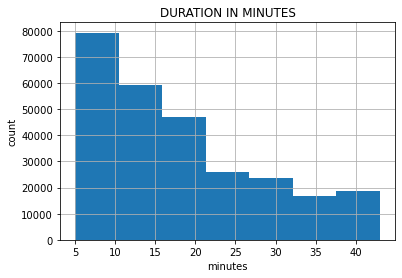

In [36]:
# So that the histogram is meaningful I will remove the outlier values from the dataset.
import matplotlib.pyplot as plt
plt.hist(duration_df[duration_df['duration_min'].isin(range(5,44))][['duration_min']],bins = 7)
plt.xlabel('minutes')
plt.ylabel('count')
plt.title('DURATION IN MINUTES')
plt.grid(True)
plt.show()

In [14]:
# Number of borrowings per day.
df4 = edbikes_df[['started_at']]
df4 = df4.assign (started_at_day = pd.to_datetime(df4['started_at']).dt.date)
df4 = df4[['started_at_day']].assign(borrowings_count=0).groupby('started_at_day').count()#.sort_values('borrowings_count',ascending=False)
df4.index = pd.to_datetime(df4.index)
df4

,borrowings_count
started_at_day,
2018-09-15,3
2018-09-16,10
2018-09-17,310
2018-09-18,101
2018-09-19,66
...,...
2021-06-26,319
2021-06-27,523
2021-06-28,293


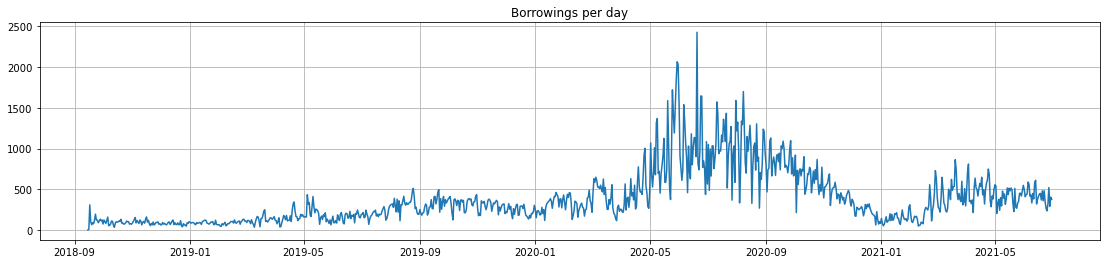

In [21]:
common_ts_kwargs = {'grid': True}
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (19,4))
ax.plot(df4)
plt.title('Borrowings per day')
ax.grid()
plt.show()

In [15]:
hour_df = edbikes_df.assign(started_at_day = pd.to_datetime(edbikes_df['started_at']).dt.date, hours = pd.to_datetime(edbikes_df['started_at']).dt.hour)
day_df = hour_df[hour_df['hours'].isin(range(6,19))]
day_df = day_df.groupby('started_at_day').count()[['hours']]

In [16]:
night_df = hour_df[~hour_df['hours'].isin(range(6,19))]
night_df = night_df.groupby('started_at_day').count()[['hours']]

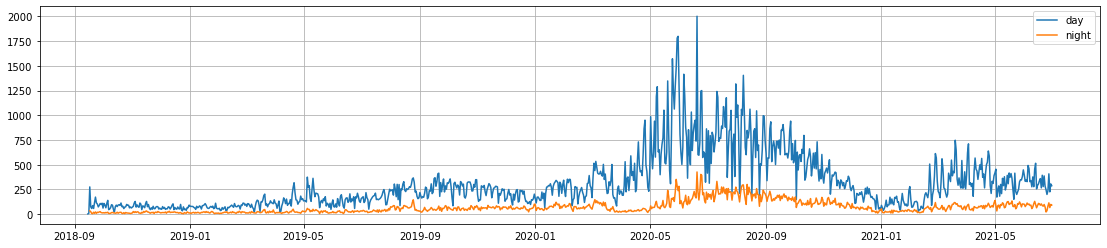

In [20]:
# Fluctuations of demand between daytime and nighttime.
fig,ax = plt.subplots(figsize=(19,4))
ax.plot(day_df)
ax.plot(night_df)
ax.legend(labels = ['day','night'])
ax.grid()
plt.show()

In [21]:
weekday_df = edbikes_df.assign(started_at_day = pd.to_datetime(edbikes_df['started_at']).dt.date, day_of_week = pd.to_datetime(edbikes_df['started_at']).dt.dayofweek)
week_df = weekday_df[weekday_df['day_of_week'].isin(range(0,5))]
week_df = week_df.groupby('started_at_day').count()[['started_at']]
weekend_df = weekday_df[~weekday_df['day_of_week'].isin(range(0,5))]
weekend_df = weekend_df.groupby('started_at_day').count()[['started_at']]
print('Rental daily average working days: ')
print('\n',week_df.describe().iloc[1,0])
print('\n','Rental daily average weekends: ')
print('\n',weekend_df.describe().iloc[1,0])
print('\n','Daily borrowings during weekends are slightly higher than during working days.')

Rental daily average working days: 

 362.217032967033

 Rental daily average weekends: 

 416.7739726027397

 Daily borrowings during weekends are slightly higher than during working days.


In [38]:
edweather_df = pd.read_csv("edinburgh_weather_202205172052.csv",delimiter=';',decimal=',')
edweather_df['date'] = pd.to_datetime(edweather_df['date'])
edweather_df = edweather_df.set_index('date')
edweather_df

,time,temp,feels,wind,gust,rain,humidity,cloud,pressure,vis
date,,,,,,,,,,
2018-09-01,00:00,11 °c,11 °c,9 km/h from S,19 km/h,0.0 mm,79%,13%,1020 mb,Excellent
2018-09-01,03:00,13 °c,12 °c,11 km/h from SSW,19 km/h,0.0 mm,76%,96%,1020 mb,Excellent
2018-09-01,06:00,14 °c,13 °c,11 km/h from SSW,19 km/h,0.0 mm,84%,100%,1020 mb,Excellent
2018-09-01,09:00,14 °c,13 °c,14 km/h from SSW,23 km/h,0.1 mm,88%,78%,1021 mb,Excellent
2018-09-01,12:00,16 °c,16 °c,15 km/h from SSW,22 km/h,0.0 mm,87%,87%,1021 mb,Excellent
...,...,...,...,...,...,...,...,...,...,...
2020-10-31,09:00,14 °c,12 °c,21 km/h from SSE,33 km/h,0.4 mm,86%,100%,993 mb,Poor
2020-10-31,12:00,14 °c,12 °c,24 km/h from SSE,37 km/h,0.4 mm,88%,94%,987 mb,Poor
2020-10-31,15:00,10 °c,6 °c,42 km/h from SW,55 km/h,0.5 mm,75%,100%,989 mb,Excellent


In [39]:
def vis (x):
    if x == 'Excellent':
        return 4
    elif x == 'Good':
        return 3
    elif x == 'Average':
        return 2
    else:
        return 1


edweather_df = (edweather_df.assign(temp_celsius = edweather_df.temp.str.extract("([-+]?\d+)").astype(int),
                   feels_celsius = edweather_df.feels.str.extract("([-+]?\d+)").astype(int),
                    wind_kmh = edweather_df.wind.str.extract("([-+]?\d+)").astype(int),
                    gust_kmh = edweather_df.gust.str.extract("([-+]?\d+)").astype(int),
                    rain_mm = edweather_df.rain.str.extract("([-+]?\d*\.\d+|[-+]?\d+)").astype(float),
                    humidity_percent = edweather_df.humidity.str.extract("([-+]?\d+)").astype(int),
                    cloud_percent = edweather_df.cloud.str.extract("([-+]?\d+)").astype(int),
                    pressure_mb = edweather_df.pressure.str.extract("([-+]?\d+)").astype(int),
                    vis_point = edweather_df.vis.apply(vis))
)[['time','temp_celsius', 'feels_celsius', 'wind_kmh', 'gust_kmh', 'rain_mm', 'humidity_percent', 'cloud_percent', 'pressure_mb', 'vis_point']]

In [40]:
edweather_df

,time,temp_celsius,feels_celsius,wind_kmh,gust_kmh,rain_mm,humidity_percent,cloud_percent,pressure_mb,vis_point
date,,,,,,,,,,
2018-09-01,00:00,11,11,9,19,0.0,79,13,1020,4
2018-09-01,03:00,13,12,11,19,0.0,76,96,1020,4
2018-09-01,06:00,14,13,11,19,0.0,84,100,1020,4
2018-09-01,09:00,14,13,14,23,0.1,88,78,1021,4
2018-09-01,12:00,16,16,15,22,0.0,87,87,1021,4
...,...,...,...,...,...,...,...,...,...,...
2020-10-31,09:00,14,12,21,33,0.4,86,100,993,1
2020-10-31,12:00,14,12,24,37,0.4,88,94,987,1
2020-10-31,15:00,10,6,42,55,0.5,75,100,989,4


In [41]:
# Modified edweather_df to show average values per day.
edweather_df = edweather_df.groupby('date').mean()
edweather_df

,temp_celsius,feels_celsius,wind_kmh,gust_kmh,rain_mm,humidity_percent,cloud_percent,pressure_mb,vis_point
date,,,,,,,,,
2018-09-01,14.375,14.000,12.125,20.125,0.0125,84.875,77.625,1020.875,4.000
2018-09-02,16.500,16.625,12.875,21.000,0.0500,87.875,70.625,1019.875,2.500
2018-09-03,11.875,11.500,8.625,13.125,0.0375,87.625,70.750,1023.250,2.875
2018-09-04,11.250,13.375,5.000,6.750,0.0000,75.125,6.750,1024.375,4.000
2018-09-05,12.500,12.625,9.375,14.125,0.0500,79.750,27.250,1022.125,3.875
...,...,...,...,...,...,...,...,...,...
2020-10-27,7.125,4.625,15.250,22.375,0.1250,86.250,54.125,988.625,3.500
2020-10-28,7.250,3.500,24.500,34.000,0.1500,83.625,87.500,990.125,4.000
2020-10-29,6.750,5.250,16.875,26.625,1.2625,87.500,84.625,999.000,3.375


In [42]:
# Added borrowings_count per day to edweather_df.
edweather_df = df4.join(edweather_df,how='inner')
edweather_df

,borrowings_count,temp_celsius,feels_celsius,wind_kmh,gust_kmh,rain_mm,humidity_percent,cloud_percent,pressure_mb,vis_point
2018-09-15,3,10.500,8.500,14.875,23.500,0.1250,83.875,58.125,1017.375,4.000
2018-09-16,10,12.875,10.625,26.500,43.125,0.1250,81.500,79.500,1008.875,4.000
2018-09-17,310,13.875,13.125,18.000,29.875,0.0250,83.000,66.125,1006.375,4.000
2018-09-18,101,14.125,13.500,16.875,28.500,0.2375,86.875,57.750,996.125,4.000
2018-09-19,66,11.750,8.625,34.750,55.625,0.3625,75.750,52.250,995.875,3.875
...,...,...,...,...,...,...,...,...,...,...
2020-10-27,437,7.125,4.625,15.250,22.375,0.1250,86.250,54.125,988.625,3.500
2020-10-28,559,7.250,3.500,24.500,34.000,0.1500,83.625,87.500,990.125,4.000
2020-10-29,478,6.750,5.250,16.875,26.625,1.2625,87.500,84.625,999.000,3.375
2020-10-30,774,10.500,8.125,20.500,28.625,0.0875,78.625,62.375,1006.875,3.625


In [44]:
# To test the effect of weather on bike rentals, we test the linear dependence of weather variables on the number of rentals.
# Effect of temperature.
edweather_df['borrowings_count'].corr(edweather_df['feels_celsius']).round(2)

0.43

In [51]:
# Effect of temperature in high season.
start_date = '2020-06-01'
end_date = '2020-08-30'
selection = (edweather_df.index>=start_date)&(edweather_df.index<=end_date)
season_df = edweather_df.loc[selection]
season_df['borrowings_count'].corr(season_df['feels_celsius']).round(2)

0.36

In [52]:
# Effect of wind.
edweather_df['borrowings_count'].corr(edweather_df['wind_kmh']).round(2)

-0.2

In [53]:
# Effect of gusty wind.
edweather_df['borrowings_count'].corr(edweather_df['gust_kmh']).round(2)

-0.24

In [54]:
# Effect of rain.
edweather_df['borrowings_count'].corr(edweather_df['rain_mm']).round(2)

-0.06

In [56]:
# Effect of humidity.
edweather_df['borrowings_count'].corr(edweather_df['humidity_percent']).round(2)

-0.21

In [57]:
# Effect of clouds.
edweather_df['borrowings_count'].corr(edweather_df['cloud_percent']).round(2)

-0.06

In [58]:
# Effect of atmospheric pressure.
edweather_df['borrowings_count'].corr(edweather_df['pressure_mb']).round(2)

0.11

In [59]:
# Effect of visibility.
edweather_df['borrowings_count'].corr(edweather_df['vis_point']).round(2)

0.06